In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
file_name = 'COVID_19_PPI/BIOGRID-PROJECT-covid19_coronavirus_project-INTERACTIONS-4.4.210.tab3.txt'

In [3]:
df = pd.read_csv(file_name, sep='\t')
df.rename(mapper=lambda col: col.lstrip('#'), axis=1, inplace=True)
df = df.applymap(lambda x: np.nan if x == "-" else x)
df.dropna(subset=['Entrez Gene Interactor A', 'Entrez Gene Interactor B'], inplace=True)
df.dropna(axis=1, inplace=True)
df

,BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Experimental System,Experimental System Type,Author,Publication Source,Organism ID Interactor A,Organism ID Interactor B,Throughput,Source Database,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,E,AP3B1,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,E,BRD4,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,E,BRD2,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,E,CWC27,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,E,ZC3H18,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29711,3383536,43740578,476,4383850,106966,nsp1,ATP1A1,Affinity Capture-MS,physical,Bermudez Y (2022),DOI:10.1101/2022.04.19.488803,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
29712,3383537,43740578,2950,4383850,109205,nsp1,GSTP1,Affinity Capture-MS,physical,Bermudez Y (2022),DOI:10.1101/2022.04.19.488803,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
29713,3383538,43740568,43740568,4383848,4383848,S,S,Co-crystal Structure,physical,Zhang X (2022),DOI:10.1101/2022.04.26.489529,2697049,2697049,Low Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2
29714,3383539,43740568,43740568,4383848,4383848,S,S,Reconstituted Complex,physical,Zhang X (2022),DOI:10.1101/2022.04.26.489529,2697049,2697049,Low Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2


In [4]:
cols = [
    'Entrez Gene Interactor A',
    'Entrez Gene Interactor B',
    'BioGRID ID Interactor A',
    'BioGRID ID Interactor B',
    'Official Symbol Interactor A',
    'Official Symbol Interactor B'
]

df = pd.DataFrame(data=df[cols].to_numpy(), columns=cols, index=list(df['BioGRID Interaction ID']))
df

,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Official Symbol Interactor A,Official Symbol Interactor B
2652341,43740570,8546,4383845,114116,E,AP3B1
2652342,43740570,23476,4383845,117036,E,BRD4
2652343,43740570,6046,4383845,111973,E,BRD2
2652344,43740570,10283,4383845,115572,E,CWC27
2652345,43740570,124245,4383845,125858,E,ZC3H18
...,...,...,...,...,...,...
3383536,43740578,476,4383850,106966,nsp1,ATP1A1
3383537,43740578,2950,4383850,109205,nsp1,GSTP1
3383538,43740568,43740568,4383848,4383848,S,S
3383539,43740568,43740568,4383848,4383848,S,S


In [5]:
def different_ids_for_symbols(db_name):
    db = {}
        
    for _, row in df.iterrows():
        for sym in ['A', 'B']:
            symbol = row[f'Official Symbol Interactor {sym}']
            interactor_id = row[f'{db_name} {sym}']
            
            ids = db.get(symbol, set())
            ids.add(interactor_id)
            db[symbol] = ids

    return db

entrez = different_ids_for_symbols('Entrez Gene Interactor')
biogrid = different_ids_for_symbols('BioGRID ID Interactor')
    
for symbol, ids in entrez.items():
    if symbol not in biogrid:
        print(f'symbol {symbol} does not exist in biogrid')
    elif len(biogrid[symbol]) != len(ids):
        print(f'lens differ {symbol}')

In [6]:
G = nx.DiGraph()

for interaction_id, (entrez_id_a, entrez_id_b, biogrid_id_a, biogrid_id_b, symbol_a, symbol_b) in df.iterrows():
    G.add_node(entrez_id_a, biogrid_id=biogrid_id_a, label=symbol_a)
    G.add_node(entrez_id_b, biogrid_id=biogrid_id_b, label=symbol_b)
    G.add_edge(entrez_id_a, entrez_id_b, interaction_id=interaction_id)
    
scores = nx.pagerank(G, alpha=0.9)
scores_sorted = sorted(scores.items(), key=lambda x: x[1], reverse=True)

node_label = lambda symbol: G.nodes[symbol]['label']

N = 20

topN = pd.DataFrame(
    [[node, node_label(node), score] for (node, score) in scores_sorted[:N]],
    columns=['entrez_id', 'symbol', 'score'])
topN

,entrez_id,symbol,score
0,43740568,S,0.008596
1,43740575,N,0.002395
2,1489678,N,0.002154
3,1489668,S,0.001866
4,1489680,nsp1ab,0.001314
5,14254594,S,0.001304
6,43740578,nsp1,0.001247
7,43740570,E,0.001162
8,1489674,ORF7a,0.001015
9,1489669,ORF3a,0.000748


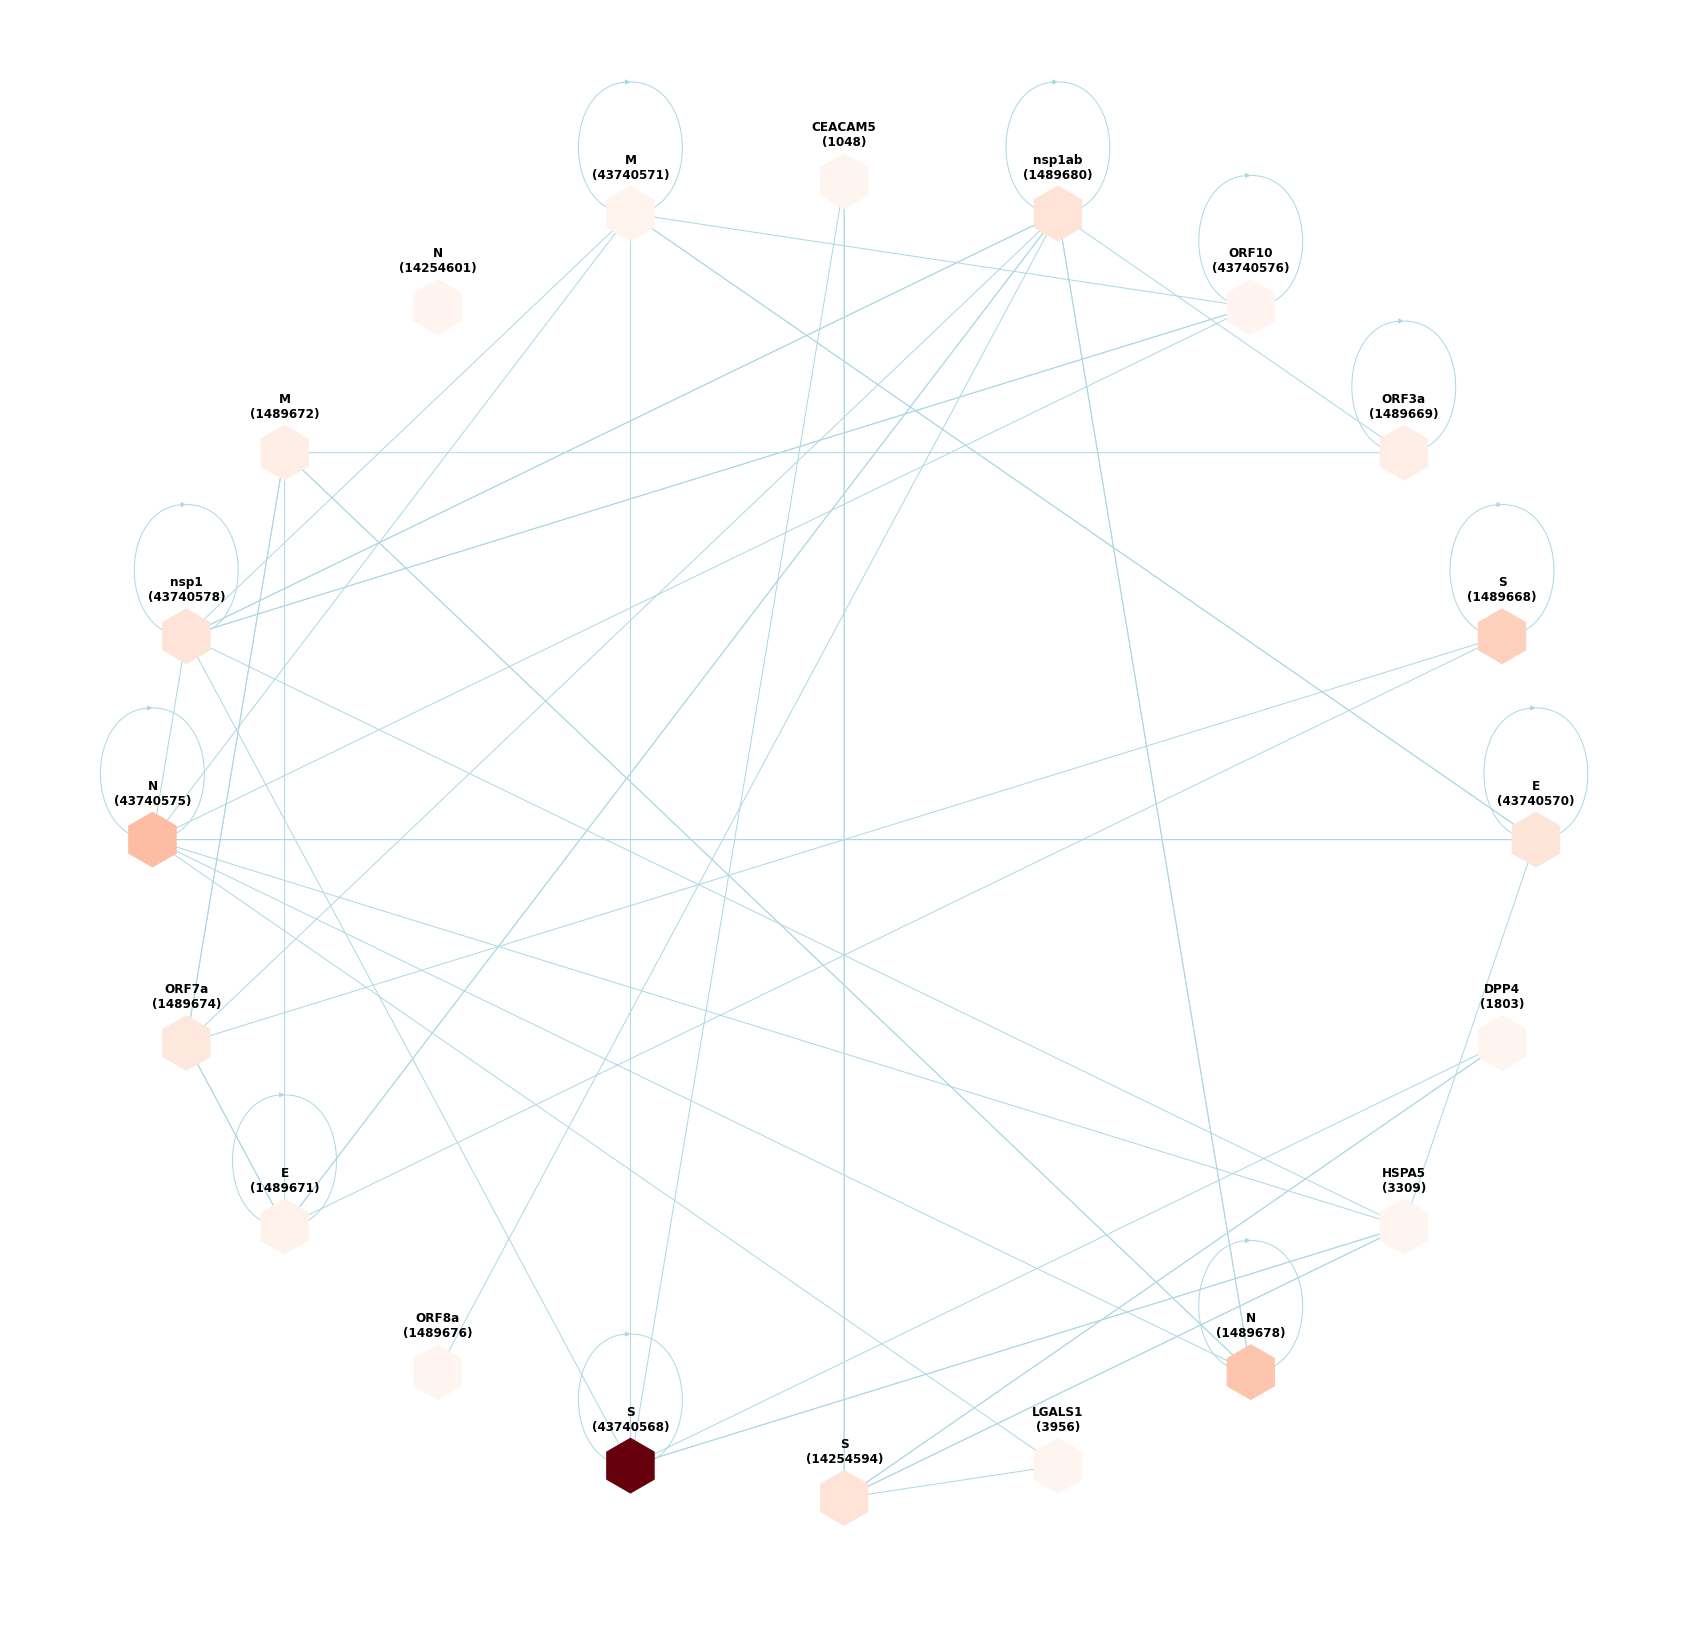

In [7]:
subg = G.subgraph(list(topN['entrez_id']))

pos = nx.circular_layout(subg)
    
plt.figure(figsize=(30, 30))

colors = [scores[node] for node in subg.nodes()]

# Iscrtavamo cvorove
nx.draw_networkx_nodes(subg, pos, cmap=plt.cm.Reds, node_color=colors, node_size=3000, node_shape='h')

# Iscrtavamo oznake cvorova
labels = {node: f'{data["label"]}\n({node})' for (node, data) in subg.nodes.items()}
label_pos = {k: (v[0], v[1]+0.07) for (k, v) in pos.items()}
nx.draw_networkx_labels(subg, label_pos, labels=labels, font_color='k', font_size=12, font_weight='bold')

# Iscrtavamo grane
nx.draw_networkx_edges(subg, pos, edgelist=subg.edges(), width=1, edge_color='lightblue')

# Iskljucujemo ose
plt.axis('off')

# I prikazujemo graf
plt.show()